### Todos:
### 1. preprocess the data to make it suitable for glove embeding:
### a. remove ' from words( don't -> dont)
### b. convert all letters to lowercase ( Hoping -> hoping)
### 2. find the frequency of each emoji to see if the dataset is balanced and balance the dataset(important)

In [52]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import interesting_labels

In [53]:
import pandas

In [62]:
def get_data():
    header = ['tweet','label']
    data_set = pandas.read_csv('cleaned_data.txt',delimiter='\t',names = header)
    return data_set

# def get_label_mapping():
#     original_list = interesting_labels.wanted_list
#     output_list = [i for i in range(len(original_list))]
#     return dict(zip(original_list,output_list))
  
def split_tweet(tweet):
    return tweet.split()    


In [63]:
data_set = get_data()

In [64]:
glove = torchtext.vocab.GloVe(name="twitter.27B",dim=50)

In [65]:
len(data_set)

41388

In [66]:
type(data_set['tweet'][0])

str

In [67]:
data_set

,tweet,label
0,hoping i dont screw up this interview,0
1,i feel like a baby kangaroo stuck in its mothe...,1
2,girl ppl should be happy i even remembered her...,0
3,"oh , the irony if misha wins the choice tv sc...",2
4,"i miss you to , you so fake now",2
5,"i miss you to , you so fake now",4
6,i know,1
7,bacolod please ? !,0
8,things can change so quickly,1
9,all me &amp ; vic do is laugh . . anybody o...,1


In [68]:
data_set

,tweet,label
0,hoping i dont screw up this interview,0
1,i feel like a baby kangaroo stuck in its mothe...,1
2,girl ppl should be happy i even remembered her...,0
3,"oh , the irony if misha wins the choice tv sc...",2
4,"i miss you to , you so fake now",2
5,"i miss you to , you so fake now",4
6,i know,1
7,bacolod please ? !,0
8,things can change so quickly,1
9,all me &amp ; vic do is laugh . . anybody o...,1


In [69]:
data_set

,tweet,label
0,hoping i dont screw up this interview,0
1,i feel like a baby kangaroo stuck in its mothe...,1
2,girl ppl should be happy i even remembered her...,0
3,"oh , the irony if misha wins the choice tv sc...",2
4,"i miss you to , you so fake now",2
5,"i miss you to , you so fake now",4
6,i know,1
7,bacolod please ? !,0
8,things can change so quickly,1
9,all me &amp ; vic do is laugh . . anybody o...,1


In [188]:
def get_tweet_words(glove_vector):
    train, valid, test = [],[],[]
    for i in range(len(data_set)):
        tweet = data_set['tweet'][i]
        if(type(tweet) != str):
            continue
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_tweet(tweet)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(data_set['label'][i]).long()
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

In [189]:
train, valid, test = get_tweet_words(glove)

In [190]:
num_classes = len(set([element[1].item() for element in train]))
num_classes

6

In [191]:
train[0]

(tensor([3653,   10,  348, 6456,   85,   53, 2706]), tensor(0))

In [192]:
valid[0]

(tensor([  10,  292,   15,   16,    4,   15,   55, 1271,  110]), tensor(2))

In [193]:
len(train)

24707

### Recurrent Neural Network Module

In [194]:
rnn_layer = nn.RNN(input_size=50,    # dimension of the input repr
                   hidden_size=50,   # dimension of the hidden units
                   batch_first=True) # input format is [batch_size, seq_len, repr_dim]

In [195]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)     # initial hidden layer
out, last_hidden = rnn_layer(tweet_input, h0)

In [196]:
print(out.shape)
print(last_hidden.shape)

torch.Size([1, 7, 50])
torch.Size([1, 1, 50])


In [197]:
out[:,-1,:]

tensor([[ 0.3269, -0.0197,  0.1099, -0.4570, -0.4542,  0.5368,  0.3074,  0.6702,
          0.5722, -0.3266, -0.2257, -0.2498, -0.3839, -0.6986, -0.0465,  0.0494,
         -0.4706, -0.4937, -0.3642,  0.2135,  0.3388, -0.2109, -0.0683, -0.7013,
         -0.4968,  0.4532,  0.1480, -0.2990, -0.3638, -0.4437, -0.2440,  0.2190,
         -0.5726, -0.6665, -0.3686,  0.4364, -0.7844, -0.3805,  0.5813,  0.3172,
          0.6580, -0.1959,  0.3453,  0.4077,  0.5829,  0.2425,  0.4825,  0.5047,
          0.6848,  0.4649]], grad_fn=<SliceBackward>)

### Building the model

In [198]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetRNN(input_size=50, hidden_size=50, num_classes=num_classes)

In [199]:
data_set.nunique()

tweet    35252
label        6
dtype: int64

In [200]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [201]:
for i, (tweets, labels) in enumerate(TweetBatcher(train, drop_last=True)):
    print(tweets.shape, labels.shape)
print(i)

torch.Size([32, 18]) torch.Size([32])
torch.Size([32, 16]) torch.Size([32])
torch.Size([32, 3]) torch.Size([32])
torch.Size([32, 30]) torch.Size([32])
torch.Size([32, 22]) torch.Size([32])
torch.Size([32, 14]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 25]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 20]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 18]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 15]) torch.Size([32])
torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 20]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 5]) torch.Size([32])
torch.Size([32, 17]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 5]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 32]) t

torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 5]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 3]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 9]) torch.Size([32])
torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 9]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 10]) torch.Size([32])
torch.Size([32, 8]) torch.Size([32])
torch.Size([32, 7]) torch.Size([32])
torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 9]) torch.Size([32])
torch.Size([32, 9]) torch.Size([

In [202]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return float(correct) / float(total)

test_loader = TweetBatcher(test, batch_size=32, drop_last=False)
get_accuracy(model, test_loader)


0.06742801603693355

In [203]:
for i in range(10):
    model = TweetRNN(input_size=50, hidden_size=50, num_classes=num_classes)
    test_loader = TweetBatcher(test, batch_size=32, drop_last=False)
    print(get_accuracy(model, test_loader))

0.07945571619487304
0.07896974851172398
0.05831612197788847
0.07265216863078605
0.0492042279188434
0.26351597618758354
0.10144575385736848
0.08200704653140566
0.2720204106426923
0.3000850443445511


In [204]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 1.142408; Train Acc 0.580743; Val Acc 0.575039
Epoch 2; Loss 1.368589; Train Acc 0.557559; Val Acc 0.549034
Epoch 3; Loss 1.146037; Train Acc 0.583277; Val Acc 0.575647
Epoch 4; Loss 1.190667; Train Acc 0.586318; Val Acc 0.580873
Epoch 5; Loss 1.059182; Train Acc 0.595101; Val Acc 0.589744
Epoch 6; Loss 0.980411; Train Acc 0.599071; Val Acc 0.592539
Epoch 7; Loss 1.255766; Train Acc 0.596579; Val Acc 0.594969
Epoch 8; Loss 1.139762; Train Acc 0.603083; Val Acc 0.598007
Epoch 9; Loss 1.107626; Train Acc 0.603083; Val Acc 0.600073
Epoch 10; Loss 0.765116; Train Acc 0.603083; Val Acc 0.601896
Epoch 11; Loss 1.173460; Train Acc 0.607517; Val Acc 0.602746
Epoch 12; Loss 1.093638; Train Acc 0.607137; Val Acc 0.603354
Epoch 13; Loss 1.034071; Train Acc 0.608319; Val Acc 0.604691
Epoch 14; Loss 1.097747; Train Acc 0.608995; Val Acc 0.604326
Epoch 15; Loss 1.183873; Train Acc 0.609924; Val Acc 0.602746
Epoch 16; Loss 0.948629; Train Acc 0.603843; Val Acc 0.600802
Epoch 17; Loss 0.

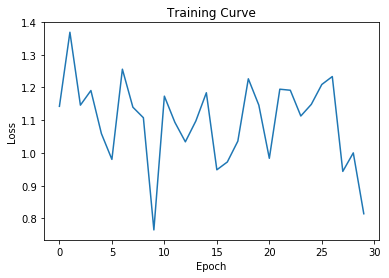

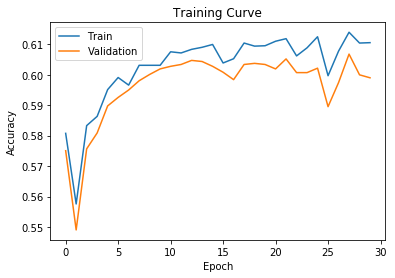

0.5985906937188678

In [205]:
model = TweetRNN(input_size=50, hidden_size=100, num_classes=num_classes)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=2e-4)
get_accuracy(model, test_loader)

### LSTM Model

In [206]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model_lstm = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=2e-4)
get_accuracy(model, test_loader)

Epoch 1; Loss 0.842505; Train Acc 0.617399; Val Acc 0.607000
Epoch 2; Loss 1.016359; Train Acc 0.610431; Val Acc 0.597886
Epoch 3; Loss 0.930321; Train Acc 0.615583; Val Acc 0.602139
Epoch 4; Loss 1.264562; Train Acc 0.618454; Val Acc 0.607486
Epoch 5; Loss 1.071538; Train Acc 0.618834; Val Acc 0.606392
Epoch 6; Loss 1.190769; Train Acc 0.617736; Val Acc 0.606757
Epoch 7; Loss 1.199129; Train Acc 0.617652; Val Acc 0.603111
Epoch 8; Loss 0.858440; Train Acc 0.616934; Val Acc 0.605906
Epoch 9; Loss 1.074517; Train Acc 0.617103; Val Acc 0.600681
Epoch 10; Loss 1.005321; Train Acc 0.619130; Val Acc 0.603962
Epoch 11; Loss 1.132572; Train Acc 0.616385; Val Acc 0.600559
Epoch 12; Loss 1.022933; Train Acc 0.618666; Val Acc 0.606271
Epoch 13; Loss 1.086898; Train Acc 0.619426; Val Acc 0.604205
Epoch 14; Loss 1.187424; Train Acc 0.622128; Val Acc 0.605663
Epoch 15; Loss 1.132978; Train Acc 0.621706; Val Acc 0.606514
Epoch 16; Loss 0.838051; Train Acc 0.624409; Val Acc 0.608701
Epoch 17; Loss 0.